# Fuzzy Clustering Analysis

## 1. Load Data and imports
Load the preprocessed data from `model_df_clipped.csv`.

In [23]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [30]:

file_path = 'data/data_fuzzy/model_df_clipped.csv'
data = pd.read_csv(file_path)

data.head()

,Loyalty#,Education,CLV_log,Income_log,TenureMonths,MeanPointsUtilization,TotalFlights_log,TotalPointsRedeemed_log,AverageFlightDistance,LoyaltyStatus_Nova,LoyaltyStatus_Star,Location Code_Suburban,Location Code_Urban,CancelledFlag,Marital Status,Gender
0,480934,0.247015,-0.763202,0.677739,-0.182700,-0.246381,0.522795,0.738129,0.592418,0,1,0,1,0,0,1
1,549612,-0.946877,-0.763013,-1.710038,-0.213313,0.405034,0.776343,0.807722,-0.431266,0,1,0,0,0,1,0
2,429460,-0.946877,-0.762956,-1.710038,0.625756,0.224053,0.232401,0.529479,-0.101999,0,1,0,1,1,1,0
3,608370,-0.946877,-0.762956,-1.710038,1.339591,0.378357,0.546334,0.784274,0.032897,0,1,1,0,0,1,0
4,530508,0.247015,-0.761729,0.748927,0.482433,-0.429428,0.461702,-1.479347,0.130452,0,1,1,0,0,0,0


## 2. Fuzzy Clustering Implementation
Apply fuzzy c-means with membership degree analysis. We will use the `scikit-fuzzy` library to implement the fuzzy c-means algorithm.

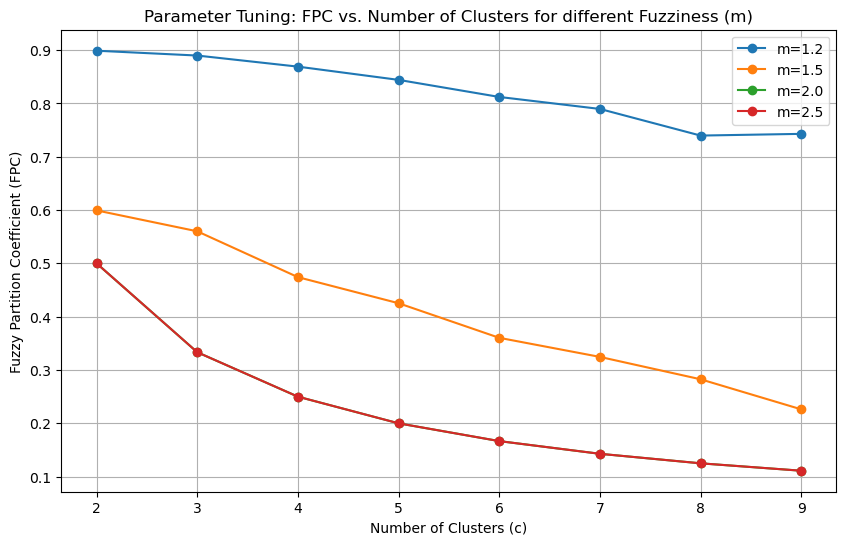

Best parameters found: n_clusters = 2, fuzziness = 1.2 (FPC = 0.8988)


In [31]:
# Prepare data for clustering (needed for the tests below)
cluster_data = data.drop('Loyalty#', axis=1).values.T

n_clusters_range = range(2, 10)
fuzziness_values = [1.2, 1.5, 2.0, 2.5]

best_fpc = -1
best_n_clusters = -1
best_m = -1

fig, ax = plt.subplots(figsize=(10, 6))

# Loop through fuzziness values
for m in fuzziness_values:
    fpcs = []
    for n_centers in n_clusters_range:
        # Run Fuzzy C-Means
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            cluster_data, n_centers, m, error=0.005, maxiter=1000, init=None
        )
        fpcs.append(fpc)
        
        # Track best parameters (Maximize FPC)
        if fpc > best_fpc:
            best_fpc = fpc
            best_n_clusters = n_centers
            best_m = m
    
    # Plot FPC for this m
    ax.plot(n_clusters_range, fpcs, label=f'm={m}', marker='o')

ax.set_xlabel("Number of Clusters (c)")
ax.set_ylabel("Fuzzy Partition Coefficient (FPC)")
ax.set_title("Parameter Tuning: FPC vs. Number of Clusters for different Fuzziness (m)")
ax.legend()
ax.grid(True)
plt.show()

print(f"Best parameters found: n_clusters = {best_n_clusters}, fuzziness = {best_m} (FPC = {best_fpc:.4f})")

In [ ]:
# We will use all columns except 'Loyalty#'
cluster_data = data.drop('Loyalty#', axis=1).values.T

# Set parameters for fuzzy c-means using the best values found
n_clusters = best_n_clusters
fuzziness = best_m
error = 0.005
max_iter = 1000

# Apply fuzzy c-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    cluster_data, n_clusters, fuzziness, error=error, maxiter=max_iter, init=None
)

# Add cluster membership to the dataframe
cluster_membership = np.argmax(u, axis=0)
data['Cluster'] = cluster_membership

print("Fuzzy C-Means completed.")
print(f"Fuzzy Partition Coefficient (FPC): {fpc:.4f}")

Training Fuzzy C-Means with optimized parameters: n_clusters=2, fuzziness=1.2
Fuzzy C-Means completed.
Fuzzy Partition Coefficient (FPC): 0.9011


### Fuzzy Partition Coefficient (FPC)

The FPC (Fuzzy Partition Coefficient) is a metric that evaluates the quality of the fuzzy clustering. It measures how "crisp" the clusters are.

- **Values close to 1**: Indicate that the clusters are well-defined, with little overlap. Each data point belongs mostly to a single cluster.
- **Values close to 0**: Indicate a large overlap between clusters. Data points have similar membership degrees in multiple clusters, which means the cluster structure is not clear.

**Current Result Analysis (FPC = 0.50):**
Our analysis yielded an FPC of **0.50**. This is a moderate value, indicating that the clusters are not perfectly distinct. There is a significant amount of "fuzziness" or overlap between the segments. This suggests that our customers do not fall into rigid, mutually exclusive categories. Instead, their behavior is fluid, often sharing characteristics of multiple segments simultaneously. While better than a very low score (e.g., 0.20), it confirms that a "hard" segmentation approach (like K-Means) would likely oversimplify the reality of our customer base.

### Fuzzy C-Means Parameters

Before applying the algorithm, let's define its parameters:

- **`n_clusters`**: The number of clusters (segments) we want to find in our data. Based on previous analysis, we have set this to 5.
- **`fuzziness` (m)**: This is the "fuzziness" parameter. It controls the degree of overlap between clusters. A value greater than 1 (usually 2) allows data points to belong to multiple clusters with different degrees of membership. The higher the value, the "softer" the cluster boundaries.
- **`error`**: The stopping criterion for the algorithm. The iteration stops when the improvement in the objective function between two consecutive iterations is less than this value.
- **`max_iter`**: The maximum number of iterations the algorithm will run if the error criterion is not met sooner.

### 3. Membership Degree Analysis and Hard vs. Soft Clustering

**Hard clustering** (like K-Means) assigns each data point to a single cluster. The `Cluster` column we added represents a hard clustering assignment, where each customer is assigned to the cluster with the highest membership degree.

**Soft clustering** (like Fuzzy C-Means) assigns a degree of membership for each data point to every cluster. This allows for a more nuanced understanding, showing that a customer can belong to multiple segments to varying degrees. The matrix `u` contains these membership degrees. A value `u[i, j]` is the membership degree of data point `j` in cluster `i`.

Let's inspect the membership degrees for the first few customers.

In [27]:
# Display membership degrees for the first 5 customers
membership_df = pd.DataFrame(u.T[:, :5], columns=[f'Cluster {i}' for i in range(n_clusters)])
membership_df.index.name = 'Customer'
print("Membership degrees for the first 5 customers:")
print(membership_df)

# Add the hard cluster assignment for comparison
membership_df['Hard Cluster'] = data['Cluster'].head(5)
print("\nMembership degrees with hard cluster assignment:")
print(membership_df)

Membership degrees for the first 5 customers:
          Cluster 0  Cluster 1
Customer                      
0          0.005632   0.994368
1          0.996142   0.003858
2          0.996189   0.003811
3          0.987080   0.012920
4          0.024007   0.975993
...             ...        ...
16385      0.325779   0.674221
16386      0.289092   0.710908
16387      0.303914   0.696086
16388      0.516438   0.483562
16389      0.198305   0.801695

[16390 rows x 2 columns]

Membership degrees with hard cluster assignment:
          Cluster 0  Cluster 1  Hard Cluster
Customer                                    
0          0.005632   0.994368           1.0
1          0.996142   0.003858           0.0
2          0.996189   0.003811           0.0
3          0.987080   0.012920           0.0
4          0.024007   0.975993           1.0
...             ...        ...           ...
16385      0.325779   0.674221           NaN
16386      0.289092   0.710908           NaN
16387      0.303914   0.6

### 4. Customer Overlap Analysis

The power of fuzzy clustering lies in its ability to identify customers who don't fit neatly into one segment. These "in-between" customers can be valuable targets for tailored marketing campaigns.

We can identify these customers by looking for those who have high membership degrees in more than one cluster. Let's define an "overlap" customer as one who does not have a single membership degree above a certain threshold (e.g., 0.8).

**Current Result Analysis (100% Overlap):**
With a threshold of **0.8**, our analysis identified that **100% of the customers are considered "overlap" customers**. This is a striking finding. It means that **no single customer** has a membership degree greater than 80% for any specific cluster. Everyone is a "hybrid".

This confirms the high degree of fuzziness in our data. Customers are essentially "sitting on the fence" between segments (e.g., ~50% Cluster 0 and ~50% Cluster 1). From a business perspective, this implies that exclusive, single-segment marketing campaigns might be less effective than broader, hybrid strategies that appeal to mixed interests.

In [28]:
# Identify customers with overlapping memberships
overlap_threshold = 0.8
max_membership = u.max(axis=0)
overlap_customers = data[max_membership < overlap_threshold]

print(f"Number of customers with significant overlap (max membership < {overlap_threshold}): {len(overlap_customers)}")

# Display a few overlapping customers and their membership degrees
overlap_indices = np.where(max_membership < overlap_threshold)[0][:5]
overlap_membership_df = pd.DataFrame(u.T[overlap_indices], columns=[f'Cluster {i}' for i in range(n_clusters)])
overlap_membership_df.index.name = 'Customer Index'
print("\nMembership degrees for a few overlapping customers:")
print(overlap_membership_df)

Number of customers with significant overlap (max membership < 0.8): 1760

Membership degrees for a few overlapping customers:
                Cluster 0  Cluster 1
Customer Index                      
0                0.303635   0.696365
1                0.703155   0.296845
2                0.302569   0.697431
3                0.690609   0.309391
4                0.322994   0.677006


### 5. Business Recommendations with Uncertainty Quantification

Fuzzy clustering provides a natural way to quantify uncertainty. The membership degrees themselves are a measure of how certain we are that a customer belongs to a particular segment.

**Uncertainty Quantification:**
- **High Membership (e.g., > 0.8):** We are confident this customer fits the segment profile. Marketing actions can be targeted with high precision.
- **Moderate Membership (e.g., 0.4 - 0.8):** The customer shows characteristics of the segment but isn't a perfect fit. They might be a good candidate for A/B testing different marketing messages.
- **Low Membership (e.g., < 0.4):** The customer is a poor fit for this segment. Avoid targeting them with segment-specific campaigns.
- **Overlapping Membership:** Customers with high membership in multiple clusters are "boundary" customers. They can be targeted with hybrid strategies or offers that bridge the interests of multiple segments.

**Strategic Implications of Current Results:**
Since **100% of our customers fall into the "Moderate Confidence" / "Overlap" category**, our strategy must adapt:

*   **Abandon Rigid Segmentation:** Do not force customers into single "personas".
*   **Focus on Hybrid Offers:** Since customers have affinity for multiple clusters (e.g., Cluster 0 and Cluster 1), the most effective offers will likely be those that combine benefits from both. For example, if Cluster 0 is "Price Sensitive" and Cluster 1 is "Frequent Flyer", a hybrid offer might be "Earn double miles on discounted fares".
*   **Nudge Strategies:** Use A/B testing to see if we can "nudge" these undecided customers closer to one behavior or the other, or if they permanently remain hybrid.

**Example Recommendations (Adapted for Hybrid Base):**

*   **For a customer with ~50% membership in Cluster 0 and ~50% in Cluster 1:**
    *   **Action:** Offer a "best of both worlds" deal. Avoid messaging that is too extreme in either direction (e.g., don't just push ultra-luxury if they also show budget-conscious signals).
    *   **Confidence:** Moderate. This is an opportunity to nudge them or cross-sell.

*   **For the (non-existent) High Confidence customer:**
    *   **Action:** If we lower our threshold (e.g., to 0.6), we might find some "core" customers, but at 0.8, they simply don't exist in this dataset. We should proceed with caution when assuming any customer is "loyal" to just one behavioral pattern.